Using device: cpu
L shape: torch.Size([10000, 10000]), L device: cpu


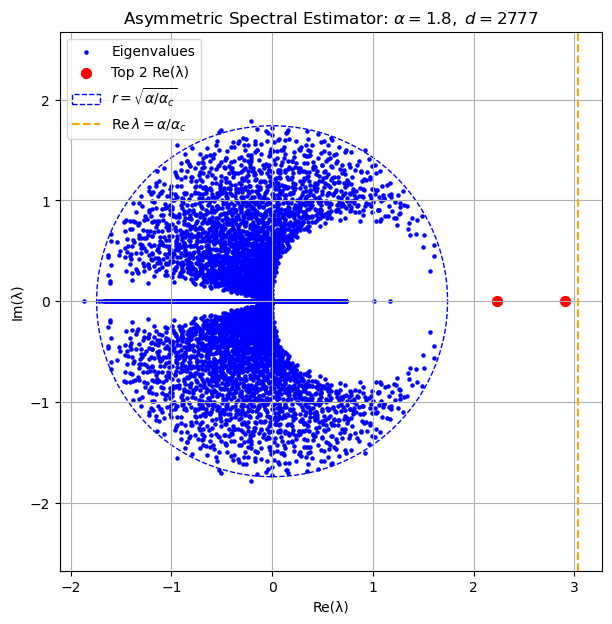

In [3]:
import os
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import kv as besselk

# 固定随机种子（可复现性）
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed(42)

# 配置参数
n = 5000  # 样本数
p = 2      # 子空间维度
alpha = 1.8
alpha_c = 0.59375
d = int(n / alpha)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Step 1: 生成输入矩阵 X ∈ ℝ^{n × d}
X = torch.randn(n, d, device=device) / np.sqrt(d)

# Step 2: 构造信号子空间 W* 和观测 Z = X W*
W_star = torch.randn(d, p, device=device)
Z = X @ W_star
z1, z2 = Z[:, 0], Z[:, 1]
y = z1 * z2  # link function: y = z1 * z2

# Step 3: 计算预处理函数 G(y) ∈ ℝ^{n × p × p}
y_cpu = y.detach().cpu().numpy()
abs_y = np.abs(y_cpu)
K1 = besselk(1, abs_y)
K0 = besselk(0, abs_y)
lambda_y = abs_y * (K1 / K0) - 1
lambda_y[np.isnan(lambda_y)] = 0  # 数值稳定处理

# 构造 G(y): 每个样本一个 2x2 对称矩阵
G_y_np = np.zeros((n, p, p), dtype=np.float32)
G_y_np[:, 0, 0] = lambda_y
G_y_np[:, 1, 1] = lambda_y
G_y_np[:, 0, 1] = y_cpu
G_y_np[:, 1, 0] = y_cpu
G_y = torch.tensor(G_y_np, device=device)

# Step 4: 构造非对称谱矩阵 L ∈ ℝ^{np × np}
XXT = X @ X.T  # shape: (n, n)
XXT.fill_diagonal_(0.0)  # 去掉主对角线

# 构造谱矩阵 L 的 (iμ, jν) 元素
A = XXT[:, :, None, None]            # shape: (n, n, 1, 1)
G_broadcast = G_y[None, :, :, :]     # shape: (1, n, p, p)
L_blocks = A * G_broadcast           # shape: (n, n, p, p)
L = L_blocks.permute(0, 2, 1, 3).reshape(n * p, n * p)  # shape: (np, np)
print(f"L shape: {L.shape}, L device: {L.device}")

# Step 5: 计算特征值（在 GPU 上）并绘图
eigvals = torch.linalg.eigvals(L)
eigvals_np = eigvals.detach().cpu().numpy()
eigvals_real = eigvals_np.real

# 获取最大两个实部的特征值索引和特征值
top2_idx = np.argsort(eigvals_real)[-2:]
top2_vals = eigvals_np[top2_idx]

# 可视化谱图
plt.figure(figsize=(7, 7))
plt.scatter(eigvals_np.real, eigvals_np.imag, s=5, color='blue', label='Eigenvalues')
plt.scatter(top2_vals.real, top2_vals.imag, color='red', s=50, label='Top 2 Re(λ)')

# 理论谱圆半径和跳跃阈值
r = np.sqrt(alpha / alpha_c)
thresh = alpha / alpha_c

circle = plt.Circle((0, 0), r, color='blue', fill=False, linestyle='--',
                    label=rf'$r = \sqrt{{\alpha / \alpha_c}}$')
plt.gca().add_artist(circle)
plt.axvline(x=thresh, color='orange', linestyle='--',
            label=rf'$\mathrm{{Re}}\,\lambda = \alpha / \alpha_c$')

# 图形设置
plt.xlabel('Re(λ)')
plt.ylabel('Im(λ)')
plt.title(rf'Asymmetric Spectral Estimator: $\alpha = {alpha},\ d = {d}$')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()


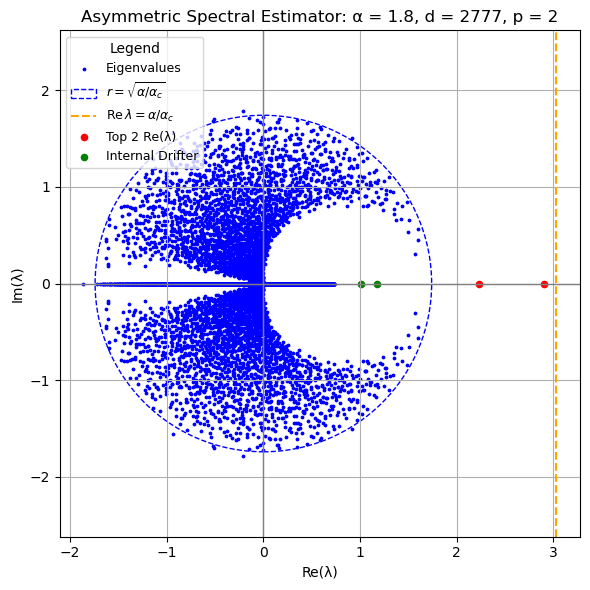

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import norm

# === 阈值定义 ===
R = np.sqrt(alpha / alpha_c)        # 蓝色圆圈半径
thresh_ext = alpha / alpha_c        # 橙色虚线位置

# 筛选实数特征值
real_mask = np.isclose(eigvals_np.imag, 0.0, atol=1e-6)
eigvals_real_only = eigvals_np[real_mask]
real_parts = eigvals_real_only.real

# 红色：前两个最大 Re(λ)
red_vals = eigvals_real_only[np.argsort(real_parts)[-2:]]

# 绿色：实部 < R 的点中，实部最大前 3 个
green_candidates = [val for val in eigvals_real_only if val.real < R]
green_vals = sorted(green_candidates, key=lambda z: -z.real)[:2]

# === 绘图开始 ===
plt.figure(figsize=(6, 6))

# 所有谱点（蓝色）
plt.scatter(eigvals_np.real, eigvals_np.imag, color="blue", s=3, label="Eigenvalues")

# 蓝色圆圈
circle = plt.Circle((0, 0), R, color="blue", linestyle="--", fill=False, label=r"$r = \sqrt{\alpha/\alpha_c}$")
plt.gca().add_artist(circle)

# 橙色虚线阈值线
plt.axvline(thresh_ext, color="orange", linestyle="--", label=r"$\mathrm{Re}\,\lambda = \alpha/\alpha_c$")

# 红色标注点（R1, R2）
for i, val in enumerate(sorted(red_vals, key=lambda x: -x.real)):
    plt.scatter(val.real, val.imag, color="red", s=20, label="Top 2 Re(λ)" if i == 0 else None)

# 绿色标注点（G1–G3）
for i, val in enumerate(sorted(green_vals, key=lambda x: -x.real)):
    plt.scatter(val.real, val.imag, color="green", s=20, label="Internal Drifter" if i == 0 else None)

# 坐标轴与标题
plt.axhline(0, color='gray', linewidth=1)
plt.axvline(0, color='gray', linewidth=1)
plt.xlabel("Re(λ)")
plt.ylabel("Im(λ)")
plt.title(f"Asymmetric Spectral Estimator: α = {alpha}, d = {d}, p = {p}")
plt.legend(loc='upper left', fontsize=9, title="Legend", title_fontsize=10)
plt.grid(True)
plt.axis("equal")
plt.tight_layout()
plt.show()




In [7]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from numpy.linalg import norm
from scipy.linalg import qr

# ==== Step 1: 定义 Generalized Overlap 评估函数 ====
def generalized_overlap_corrected(W_star, eigvals_np, eigvecs_np, target_vals, label_prefix, X):
    results = []
    d = W_star.shape[0]
    W_orth, _ = qr(W_star, mode='economic')  # 正交化
    X_cpu = X.cpu().numpy().T  # shape: (d, n)

    for i, val in enumerate(target_vals):
        idx = np.argmin(np.abs(eigvals_np - val))
        v_hat = eigvecs_np[:, idx]
        V = v_hat.reshape(-1, 2)  # shape: (n, 2)
        U = X_cpu @ V  # shape: (d, 2)

        for j in range(2):
            u = U[:, j]
            u_hat = u / norm(u)
            q = norm(W_orth.T @ u_hat)**2
            results.append((f"{label_prefix}{i+1}-{j+1}", val, q))
    return results

# ==== Step 2: 谱分解与变量准备 ====
eigvals, eigvecs = torch.linalg.eig(L)
eigvals_np = eigvals.cpu().numpy()
eigvecs_np = eigvecs.cpu().numpy()
W_star_np = W_star.cpu().numpy()

# ==== Step 3: 单点 overlap 计算 ====
results_red = generalized_overlap_corrected(W_star_np, eigvals_np, eigvecs_np, red_vals, "Red", X)
results_green = generalized_overlap_corrected(W_star_np, eigvals_np, eigvecs_np, green_vals, "Green", X)

# ==== Step 4: 合并与 DataFrame 构造 ====
all_results = results_red + results_green
df_result = pd.DataFrame(sorted(all_results, key=lambda x: -x[2]),
                         columns=["Label", "Eigenvalue", "Overlap_q"])



print(df_result)



      Label          Eigenvalue  Overlap_q
0  Green2-2  1.012436+0.000000j   0.186159
1  Green2-1  1.012436+0.000000j   0.186159
2  Green1-1  1.171297+0.000000j   0.170760
3  Green1-2  1.171297+0.000000j   0.170760
4    Red1-1  2.235321+0.000000j   0.147581
5    Red1-2  2.235321+0.000000j   0.147581
6    Red2-2  2.906451+0.000000j   0.142599
7    Red2-1  2.906451+0.000000j   0.142599


In [13]:
import numpy as np
import pandas as pd
from numpy.linalg import norm
from itertools import combinations
from scipy.linalg import qr

# === 第二步：定义 rank-2 overlap 计算函数（不使用 Pt 编号）===
def rank2_overlap_from_labels(W_star, eigvals_np, eigvecs_np, df_result, X):
    results = []
    d = W_star.shape[0]
    W_orth, _ = qr(W_star, mode='economic')
    X_cpu = X.cpu().numpy().T  # shape (d, n)

    v_map = {}  # Label -> 向量

    for i, row in enumerate(df_result.itertuples()):
        label = row.Label
        val = row.Eigenvalue
        idx = np.argmin(np.abs(eigvals_np - val))
        v_hat = eigvecs_np[:, idx]
        V = v_hat.reshape(-1, 2)  # shape: (n, 2)
        j = 0 if '1' in label[-3:] else 1  # 通过 Label 末尾判断是第1还是第2个方向
        v_map[label] = V[:, j]

    # 枚举所有不重复组合
    for (id1, v1), (id2, v2) in combinations(v_map.items(), 2):
        U = X_cpu @ np.column_stack([v1, v2])  # shape (d, 2)
        U, _ = qr(U, mode='economic')  # orthonormalize
        q = np.linalg.norm(W_orth.T @ U, ord='fro')**2  # Frobenius norm squared
        results.append((f"{id1} + {id2}", q))

    return pd.DataFrame(results, columns=["ComboLabel", "Rank2_Overlap_q"])\
             .sort_values("Rank2_Overlap_q", ascending=False)\
             .reset_index(drop=True)


# === 第三步：调用函数 ===
# 假设以下变量已存在：
# - W_star_np: (d, 2)
# - eigvals_np, eigvecs_np: 特征值与特征向量（来自 torch）
# - df_result: 包含单点标签 ["Label", "Eigenvalue", "Overlap_q"]
# - X: 输入矩阵 (n, d)

df_rank2 = rank2_overlap_from_labels(W_star_np, eigvals_np, eigvecs_np, df_result, X)

# === 第四步：输出结果 ===
pd.set_option("display.max_rows", None)
print(df_rank2)


             ComboLabel  Rank2_Overlap_q
0   Green2-2 + Green1-1         0.357262
1   Green2-2 + Green1-2         0.357262
2   Green2-1 + Green1-1         0.357262
3   Green2-1 + Green1-2         0.357262
4     Green2-2 + Red1-1         0.334138
5     Green2-2 + Red1-2         0.334138
6     Green2-1 + Red1-2         0.334138
7     Green2-1 + Red1-1         0.334138
8     Green1-1 + Red2-1         0.313764
9     Green1-2 + Red2-1         0.313764
10    Green1-1 + Red2-2         0.313763
11    Green1-2 + Red2-2         0.313763
12      Red1-2 + Red2-1         0.290497
13      Red1-2 + Red2-2         0.290497
14      Red1-1 + Red2-1         0.290497
15      Red1-1 + Red2-2         0.290497
16  Green2-2 + Green2-1         0.238269
17    Green2-1 + Red2-2         0.188935
18    Green2-1 + Red2-1         0.188935
19    Green2-2 + Red2-2         0.188935
20    Green2-2 + Red2-1         0.188935
21    Green1-1 + Red1-1         0.177522
22    Green1-2 + Red1-2         0.177522
23    Green1-2 +

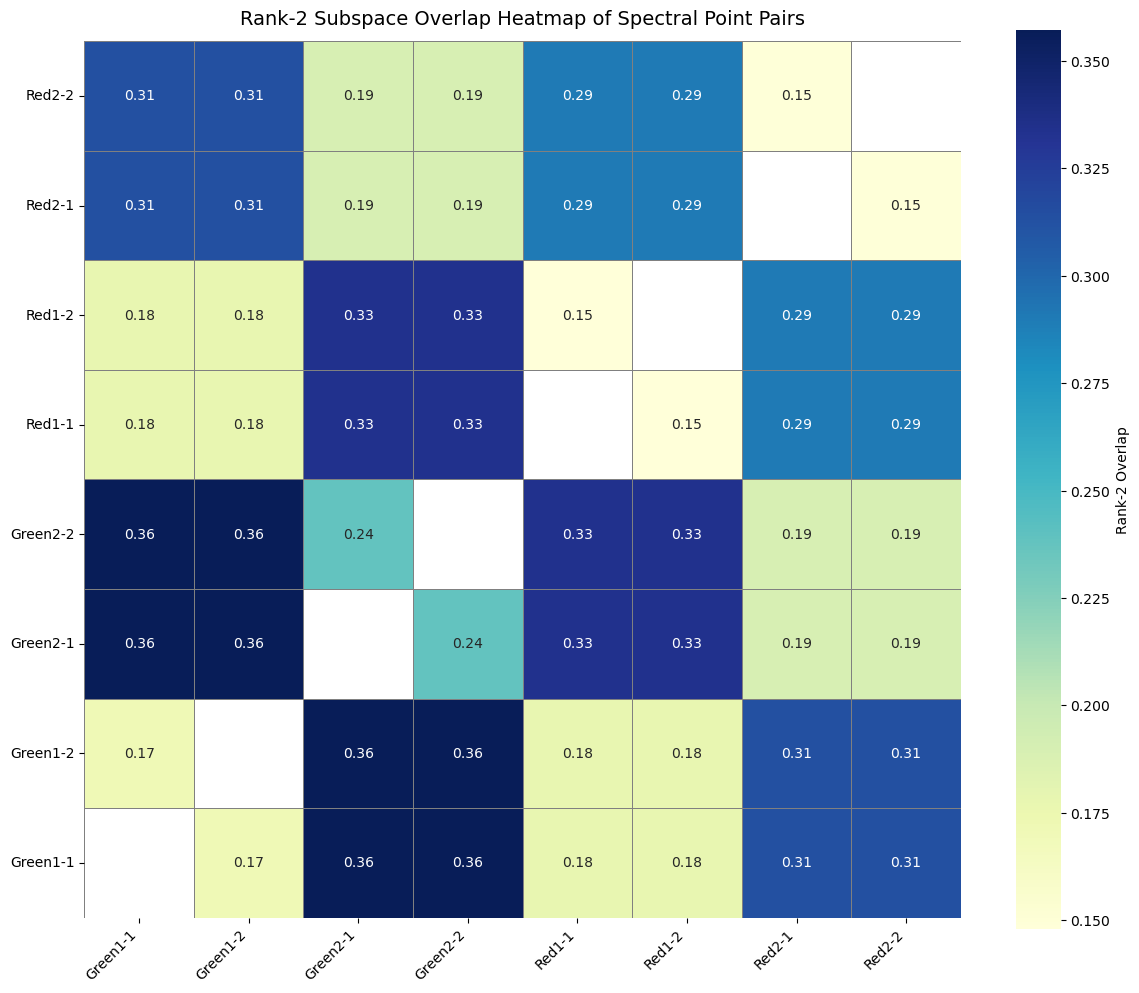

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import re

# === Step 1: 构建排序函数 ===
def custom_sort_key(label):
    try:
        color = "green" if label.lower().startswith("green") else "red"
        nums = re.findall(r'\d+', label)  # 提取所有数字
        if len(nums) < 2:
            raise ValueError(f"Label format error: {label}")
        return (0 if color == "green" else 1, int(nums[0]), int(nums[1]))
    except Exception as e:
        print(f"[Label Sorting Error] {label}: {e}")
        return (999, 999, 999)

# === Step 2: 提取所有唯一点名并排序 ===
all_labels = sorted(
    set(sum([label.split(' + ') for label in df_rank2['ComboLabel'] if isinstance(label, str)], [])),
    key=custom_sort_key
)

# === Step 3: 创建空对称矩阵 ===
heatmap_matrix = pd.DataFrame(np.nan, index=all_labels, columns=all_labels)

# === Step 4: 填入 Rank2 Overlap 值 ===
for _, row in df_rank2.iterrows():
    if isinstance(row['ComboLabel'], str) and ' + ' in row['ComboLabel']:
        a, b = row['ComboLabel'].split(' + ')
        heatmap_matrix.loc[a, b] = row['Rank2_Overlap_q']
        heatmap_matrix.loc[b, a] = row['Rank2_Overlap_q']

# 对角线不绘制
np.fill_diagonal(heatmap_matrix.values, np.nan)

# === Step 5: 找出 Top-5 的组合 ===
top5 = df_rank2.nlargest(5, 'Rank2_Overlap_q')

# === Step 6: 绘制热力图 ===
plt.figure(figsize=(12, 10))
ax = sns.heatmap(heatmap_matrix, annot=True, fmt=".2f", cmap="YlGnBu", square=True,
                 cbar_kws={'label': 'Rank-2 Overlap'}, linewidths=0.5, linecolor='gray')

plt.title("Rank-2 Subspace Overlap Heatmap of Spectral Point Pairs", fontsize=14, pad=12)



# 坐标轴设置
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
ax.invert_yaxis()

# 紧凑布局
plt.tight_layout()
plt.show()


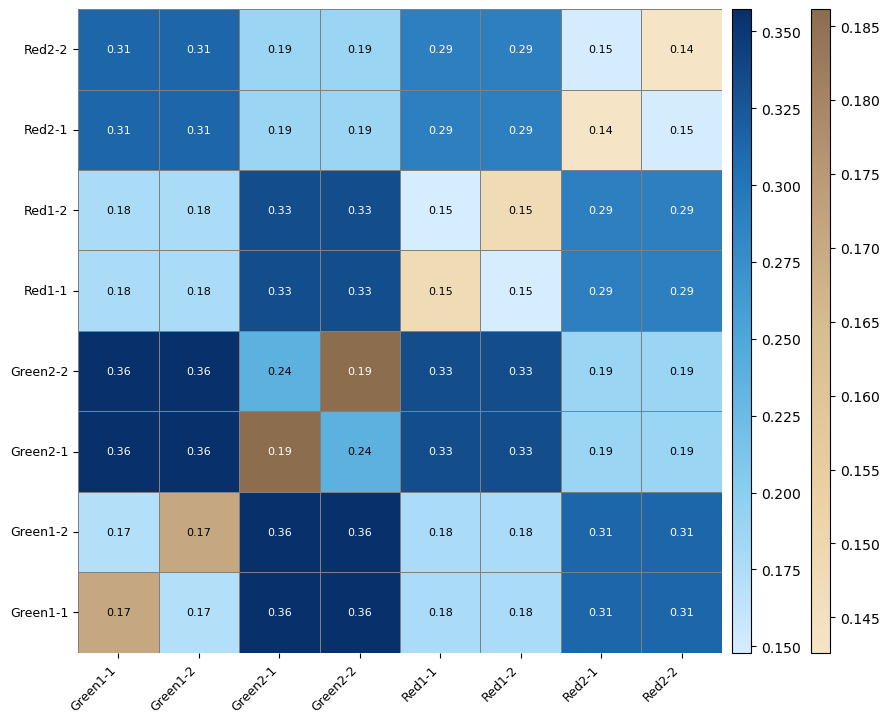

In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, to_rgb
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.cm import ScalarMappable

# === Step 1: 构建矩阵 ===
all_labels = sorted(set(df_result["Label"]))
heatmap_matrix = pd.DataFrame(np.nan, index=all_labels, columns=all_labels)

for _, row in df_rank2.iterrows():
    a, b = row['ComboLabel'].split(' + ')
    heatmap_matrix.loc[a, b] = row['Rank2_Overlap_q']
    heatmap_matrix.loc[b, a] = row['Rank2_Overlap_q']

for _, row in df_result.iterrows():
    label = row['Label']
    heatmap_matrix.loc[label, label] = row['Overlap_q']

# === Step 2: 构造 mask 和 annot ===
mask_rank1 = ~np.eye(len(all_labels), dtype=bool)
mask_rank2 = np.eye(len(all_labels), dtype=bool)

annot_matrix_rank1 = heatmap_matrix.where(~mask_rank1).round(2).astype(str).mask(mask_rank1, "")
annot_matrix_rank2 = heatmap_matrix.where(~mask_rank2).round(2).astype(str).mask(mask_rank2, "")

# === Step 3: 自定义 colormap ===
# 蓝色渐变（Rank-2）
cmap_rank2 = LinearSegmentedColormap.from_list("bright_blue_gradient", [
    "#D6ECFF",  # 极浅蓝（几乎白蓝过渡）
    "#89CFF0",  # 宝宝蓝（清新专业）
    "#4CA5D9",  # 主体蓝色（明亮）
    "#2171B5",  # 稍深蓝
    "#08306B"   # 压轴深蓝
])

# 色值列表从浅到深（棕色系）
cmap_rank1 = LinearSegmentedColormap.from_list("custom_rank1_softbrown", [
    "#F5E5C6",  # 浅奶茶
    "#EBD0A4",  # 米杏色
    "#D7BD92",  # 金棕色（中等）
    "#B99876",  # 柔和深杏
    "#8C6D4E"   # 稍暗但不沉
])

# === Step 4: 色阶范围 ===
rank1_values = heatmap_matrix.values[np.eye(len(all_labels), dtype=bool)]
rank2_values = heatmap_matrix.values[~np.eye(len(all_labels), dtype=bool)]

rank1_min, rank1_max = np.nanmin(rank1_values), np.nanmax(rank1_values)
rank2_min, rank2_max = np.nanmin(rank2_values), np.nanmax(rank2_values)

# === Step 5: 白/黑字体判断函数 ===
def get_text_color(value, cmap, vmin, vmax):
    """根据背景亮度自动设置文字为黑色或白色"""
    rgba = cmap((value - vmin) / (vmax - vmin))
    r, g, b = to_rgb(rgba[:3])
    luminance = 0.299 * r + 0.587 * g + 0.114 * b
    return 'black' if luminance > 0.5 else 'white'

# === Step 6: 绘图 ===
fig, ax = plt.subplots(figsize=(9, 8))

# 绘制背景蓝色（rank-2）
sns.heatmap(
    heatmap_matrix,
    mask=mask_rank2,
    cmap=cmap_rank2,
    annot=False,
    fmt="",
    square=True,
    cbar=False,
    linewidths=0.5,
    linecolor='gray',
    ax=ax
)

# 绘制背景橙色（rank-1）
sns.heatmap(
    heatmap_matrix,
    mask=mask_rank1,
    cmap=cmap_rank1,
    annot=False,
    fmt="",
    square=True,
    cbar=False,
    linewidths=0.5,
    linecolor='gray',
    ax=ax
)

# 添加数值文字（自动字体颜色）
for i in range(len(all_labels)):
    for j in range(len(all_labels)):
        value = heatmap_matrix.iloc[i, j]
        if pd.isna(value):
            continue
        is_rank1 = (i == j)
        cmap = cmap_rank1 if is_rank1 else cmap_rank2
        vmin = rank1_min if is_rank1 else rank2_min
        vmax = rank1_max if is_rank1 else rank2_max
        color = get_text_color(value, cmap, vmin, vmax)
        ax.text(j + 0.5, i + 0.5, f"{value:.2f}", 
                ha='center', va='center', color=color, fontsize=8)

# === Step 7: 添加双色条 ===
divider = make_axes_locatable(ax)
cax1 = divider.append_axes("right", size="3%", pad=0.1)
cax2 = divider.append_axes("right", size="3%", pad=0.6)

sm1 = ScalarMappable(cmap=cmap_rank2, norm=plt.Normalize(rank2_min, rank2_max))
sm1.set_array([])
fig.colorbar(sm1, cax=cax1)

sm2 = ScalarMappable(cmap=cmap_rank1, norm=plt.Normalize(rank1_min, rank1_max))
sm2.set_array([])
fig.colorbar(sm2, cax=cax2)

# === Step 8: 美化 ===

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=9)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=9)
ax.invert_yaxis()
plt.tight_layout()
plt.show()


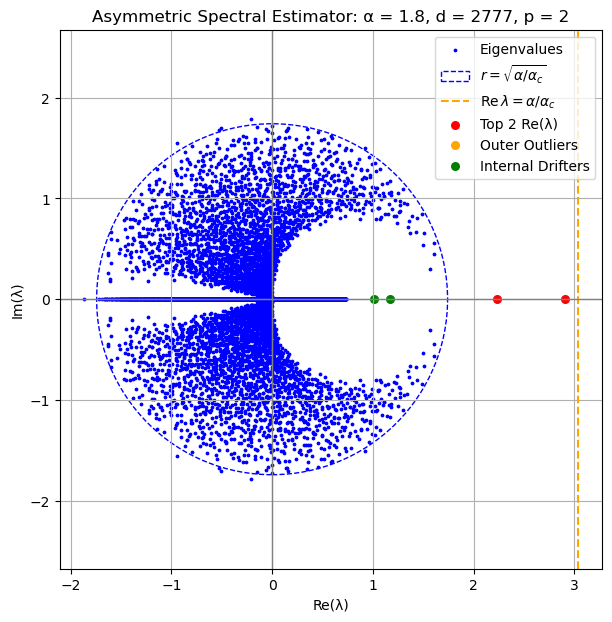


=== Alignment Score for Individual Eigenvalues ===
     Type                   λ  Alignment Score
0  Green1  1.171297+0.000000j         0.217226
1  Green2  1.012436+0.000000j         0.329795
2    Red1  2.906451+0.000000j         0.222111
3    Red2  2.235321+0.000000j         0.193813

=== Alignment Score for Pairs of Eigenvalues ===
            Pair                  λ1                  λ2  Alignment Score
3    Green2-Red1  1.012436+0.000000j  2.906451+0.000000j         0.329795
4    Green2-Red2  1.012436+0.000000j  2.235321+0.000000j         0.329795
5      Red1-Red2  2.906451+0.000000j  2.235321+0.000000j         0.222111
0  Green1-Green2  1.171297+0.000000j  1.012436+0.000000j         0.217226
1    Green1-Red1  1.171297+0.000000j  2.906451+0.000000j         0.217226
2    Green1-Red2  1.171297+0.000000j  2.235321+0.000000j         0.217226


NameError: name 'heatmap_df' is not defined

In [19]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from numpy.linalg import norm
from scipy.linalg import qr
from itertools import combinations

# ========== 对齐度函数 ==========
def alignment_score(W_hat, W_star):
    Q1, _ = qr(W_hat, mode='economic')
    Q2, _ = qr(W_star, mode='economic')
    overlap = Q1.T @ Q2
    _, s, _ = np.linalg.svd(overlap)
    return np.mean(s)

# ========== 子空间提取（单个特征值） ==========
def extract_W_from_eigenvectors(eigvecs_np, eigval_target, X, W_star, p=2, label=""):
    idx = np.argmin(np.abs(eigvals_np - eigval_target))
    v_hat = eigvecs_np[:, idx]
    V = v_hat.reshape(-1, p)
    U = (X.cpu().numpy().T) @ V
    W_hat = U / np.linalg.norm(U, axis=0, keepdims=True)
    score = alignment_score(W_hat, W_star.cpu().numpy())
    return (label, eigval_target, score)

# ========== 子空间提取（特征值对组合） ==========
def extract_W_from_eigpair(eigvecs_np, eigvals_np, eigval_pair, X, W_star, p=2, label=""):
    idx1 = np.argmin(np.abs(eigvals_np - eigval_pair[0]))
    idx2 = np.argmin(np.abs(eigvals_np - eigval_pair[1]))
    v1 = eigvecs_np[:, idx1]
    v2 = eigvecs_np[:, idx2]
    V1 = v1.reshape(-1, p)
    V2 = v2.reshape(-1, p)
    V = np.hstack([V1, V2])
    U = X.cpu().numpy().T @ V
    W_hat = U[:, :p]
    W_hat = W_hat / norm(W_hat, axis=0, keepdims=True)
    score = alignment_score(W_hat, W_star.cpu().numpy())
    return (label, eigval_pair[0], eigval_pair[1], score)

# ========== 提取谱信息 ==========
eigvals, eigvecs = torch.linalg.eig(L)
eigvals_np = eigvals.cpu().numpy()
eigvecs_np = eigvecs.cpu().numpy()

# ========== 分类特征值（红橙绿） ==========


# ==== 基础变量 ====
R = np.sqrt(alpha / alpha_c)  # 半径阈值
eigvals_np = eigvals.cpu().numpy()
eigvals_real_only = [z for z in eigvals_np if np.isclose(z.imag, 0.0, atol=1e-6)]  # 只取实数谱点

# ==== 1. 红色点（Red）：半径外的前两个最大实部特征值 ====
outside_radius = [z for z in eigvals_real_only if abs(z) > R and z.real > 0]
red_vals = sorted(outside_radius, key=lambda z: z.real, reverse=True)[:2]

# ==== 2. 橙色点（Orange）：半径外、非红色的其他正实数特征值 ====
orange_vals = [z for z in outside_radius if z not in red_vals]

# ==== 3. 绿色点（Green）：半径内、落在实数轴上的前 n 个实部最大的特征值 ====
green_candidates = [z for z in eigvals_real_only if abs(z) <= R]
green_vals = sorted(green_candidates, key=lambda z: z.real, reverse=True)[:2]  # 可改为 [:n]





# ========== 正确编号（每组内实部大的是1） ==========
green_vals_sorted = sorted(green_vals, key=lambda z: z.real, reverse=True)
green_labels = [(f"Green{i+1}", z) for i, z in enumerate(green_vals_sorted)]

orange_vals_sorted = sorted(orange_vals, key=lambda z: z.real, reverse=True)
orange_labels = [(f"Orange{i+1}", z) for i, z in enumerate(orange_vals_sorted)]

red_vals_sorted = sorted(red_vals, key=lambda z: z.real, reverse=True)
red_labels = [(f"Red{i+1}", z) for i, z in enumerate(red_vals_sorted)]

# ========== 合并标签 ==========
all_labels = green_labels + orange_labels + red_labels
label_order = [label for label, _ in all_labels]  # Green1 Green2 Orange1 Orange2 Red1 Red2

# ========== 【一次性谱图绘制】 ==========
plt.figure(figsize=(7, 7))
plt.scatter(eigvals_np.real, eigvals_np.imag, color="blue", s=3, label="Eigenvalues")
circle = plt.Circle((0, 0), R, color="blue", linestyle="--", fill=False, label=r"$r = \sqrt{\alpha/\alpha_c}$")
plt.gca().add_artist(circle)
plt.axvline(thresh_ext, color="orange", linestyle="--", label=r"$\mathrm{Re}\,\lambda = \alpha/\alpha_c$")
plt.scatter([z.real for _, z in red_labels], [z.imag for _, z in red_labels], color="red", s=30, label="Top 2 Re(λ)")
plt.scatter([z.real for _, z in orange_labels], [z.imag for _, z in orange_labels], color="orange", s=30, label="Outer Outliers")
plt.scatter([z.real for _, z in green_labels], [z.imag for _, z in green_labels], color="green", s=30, label="Internal Drifters")
plt.axhline(0, color='gray', linewidth=1)
plt.axvline(0, color='gray', linewidth=1)
plt.xlabel("Re(λ)")
plt.ylabel("Im(λ)")
plt.title(f"Asymmetric Spectral Estimator: α = {alpha}, d = {d}, p = 2")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()

# ========== Code 1：单点对齐得分 ==========
results_single = []
for label, z in all_labels:
    results_single.append(extract_W_from_eigenvectors(eigvecs_np, z, X, W_star, p=2, label=label))
df_single = pd.DataFrame(results_single, columns=["Type", "λ", "Alignment Score"])
print("\n=== Alignment Score for Individual Eigenvalues ===")
print(df_single)

# ========== Code 2：两两组合对齐得分 ==========
results_pair = []
for (label1, z1), (label2, z2) in combinations(all_labels, 2):
    pair_label = f"{label1}-{label2}"
    results_pair.append(extract_W_from_eigpair(eigvecs_np, eigvals_np, (z1, z2), X, W_star, p=2, label=pair_label))
df_pair = pd.DataFrame(results_pair, columns=["Pair", "λ1", "λ2", "Alignment Score"])
print("\n=== Alignment Score for Pairs of Eigenvalues ===")
print(df_pair.sort_values(by="Alignment Score", ascending=False))

# ========== Code 3：热力图绘制 ==========


# ========== 创建热力图数据 ==========
# 初始化 DataFrame
heatmap_df = pd.DataFrame(np.nan, index=label_order, columns=label_order)

# 填入单点（对角线）得分
for _, row in df_single.iterrows():
    label = row["Type"]
    score = row["Alignment Score"]
    heatmap_df.loc[label, label] = score

# 填入两两组合（非对角线）得分
for _, row in df_pair.iterrows():
    label1, label2 = row["Pair"].split("-")
    score = row["Alignment Score"]
    heatmap_df.loc[label1, label2] = score
    heatmap_df.loc[label2, label1] = score  # 对称填充

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes



# 颜色列表
diag_colors = ["#FAEED9", "#F5E3C2", "#F5DBD4", "#F0C7BC", "#E58B6E"]
offdiag_colors = ["#DFE9DF", "#B2C6AB", "#C2DED7", "#6DA798", "#3E7F84"]
diag_cmap = LinearSegmentedColormap.from_list("diag_cmap", diag_colors)
offdiag_cmap = LinearSegmentedColormap.from_list("offdiag_cmap", offdiag_colors)



# 创建 mask
mask_diag = pd.DataFrame(True, index=label_order, columns=label_order)
np.fill_diagonal(mask_diag.values, False)
mask_offdiag = ~mask_diag

# 值范围
vmin = np.nanmin(heatmap_df.values)
vmax = np.nanmax(heatmap_df.values)

# 创建图形
fig, ax = plt.subplots(figsize=(8, 7))

# plot1: off-diagonal（Rank-2）
sns.heatmap(heatmap_df, mask=mask_diag, cmap=offdiag_cmap, vmin=vmin, vmax=vmax,
            square=True, linewidths=0.5, cbar=False, ax=ax)

# 添加紧凑 colorbar
cbar_ax1 = inset_axes(ax, width="3%", height="40%", loc='upper right', bbox_to_anchor=(0.08, 0, 1, 1), bbox_transform=ax.transAxes, borderpad=0)
sm1 = plt.cm.ScalarMappable(cmap=offdiag_cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar1 = fig.colorbar(sm1, cax=cbar_ax1)
cbar1.set_label("Rank-2 Alignment Score", fontsize=9)

# plot2: diagonal（Rank-1）
sns.heatmap(heatmap_df, mask=mask_offdiag, cmap=diag_cmap, vmin=vmin, vmax=vmax,
            square=True, linewidths=0.5, cbar=False, ax=ax)

# 添加第二个 colorbar
cbar_ax2 = inset_axes(ax, width="3%", height="40%", loc='lower right', bbox_to_anchor=(0.08, 0, 1, 1), bbox_transform=ax.transAxes, borderpad=0)
sm2 = plt.cm.ScalarMappable(cmap=diag_cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar2 = fig.colorbar(sm2, cax=cbar_ax2)
cbar2.set_label("Rank-1 Alignment Score", fontsize=9)

# 注释数值
for i in range(len(label_order)):
    for j in range(len(label_order)):
        val = heatmap_df.iloc[i, j]
        if not np.isnan(val):
            ax.text(j + 0.5, i + 0.5, f"{val:.3f}", ha='center', va='center', fontsize=10)

# 美化

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.invert_yaxis()

plt.tight_layout()
plt.subplots_adjust(left=0.05, right=0.90, top=0.95, bottom=0.05)

plt.show()



/var/folders/kl/6hy0lk_14w14xqln8byr8l940000gn/T/ipykernel_12746/1408444067.py:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


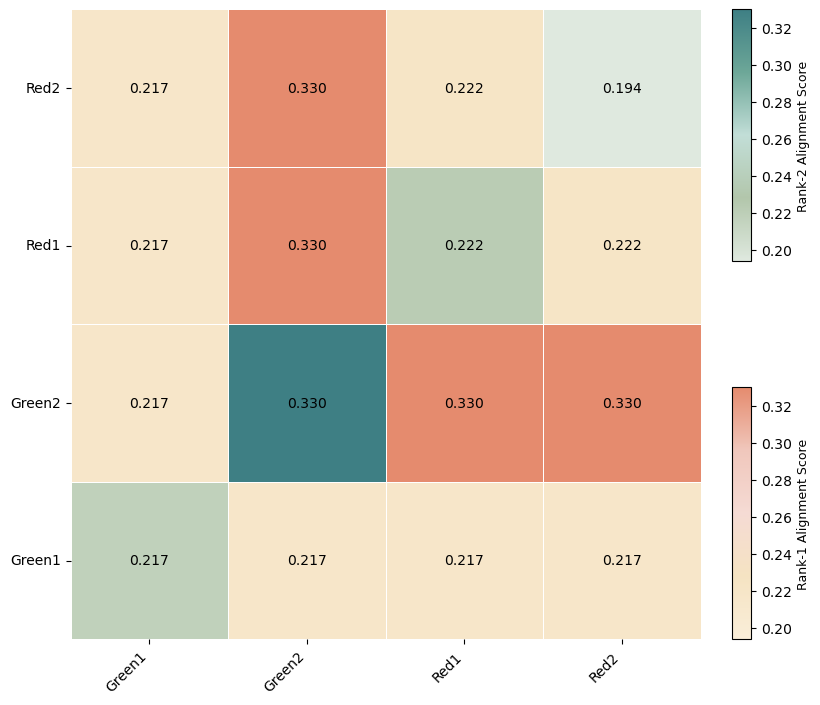

In [21]:
# ========== 创建热力图数据 ==========
# 初始化 DataFrame
heatmap_df = pd.DataFrame(np.nan, index=label_order, columns=label_order)

# 填入单点（对角线）得分
for _, row in df_single.iterrows():
    label = row["Type"]
    score = row["Alignment Score"]
    heatmap_df.loc[label, label] = score

# 填入两两组合（非对角线）得分
for _, row in df_pair.iterrows():
    label1, label2 = row["Pair"].split("-")
    score = row["Alignment Score"]
    heatmap_df.loc[label1, label2] = score
    heatmap_df.loc[label2, label1] = score  # 对称填充

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes



# 颜色列表
diag_colors = ["#FAEED9", "#F5E3C2", "#F5DBD4", "#F0C7BC", "#E58B6E"]
offdiag_colors = ["#DFE9DF", "#B2C6AB", "#C2DED7", "#6DA798", "#3E7F84"]
diag_cmap = LinearSegmentedColormap.from_list("diag_cmap", diag_colors)
offdiag_cmap = LinearSegmentedColormap.from_list("offdiag_cmap", offdiag_colors)



# 创建 mask
mask_diag = pd.DataFrame(True, index=label_order, columns=label_order)
np.fill_diagonal(mask_diag.values, False)
mask_offdiag = ~mask_diag

# 值范围
vmin = np.nanmin(heatmap_df.values)
vmax = np.nanmax(heatmap_df.values)

# 创建图形
fig, ax = plt.subplots(figsize=(8, 7))

# plot1: off-diagonal（Rank-2）
sns.heatmap(heatmap_df, mask=mask_diag, cmap=offdiag_cmap, vmin=vmin, vmax=vmax,
            square=True, linewidths=0.5, cbar=False, ax=ax)

# 添加紧凑 colorbar
cbar_ax1 = inset_axes(ax, width="3%", height="40%", loc='upper right', bbox_to_anchor=(0.08, 0, 1, 1), bbox_transform=ax.transAxes, borderpad=0)
sm1 = plt.cm.ScalarMappable(cmap=offdiag_cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar1 = fig.colorbar(sm1, cax=cbar_ax1)
cbar1.set_label("Rank-2 Alignment Score", fontsize=9)

# plot2: diagonal（Rank-1）
sns.heatmap(heatmap_df, mask=mask_offdiag, cmap=diag_cmap, vmin=vmin, vmax=vmax,
            square=True, linewidths=0.5, cbar=False, ax=ax)

# 添加第二个 colorbar
cbar_ax2 = inset_axes(ax, width="3%", height="40%", loc='lower right', bbox_to_anchor=(0.08, 0, 1, 1), bbox_transform=ax.transAxes, borderpad=0)
sm2 = plt.cm.ScalarMappable(cmap=diag_cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar2 = fig.colorbar(sm2, cax=cbar_ax2)
cbar2.set_label("Rank-1 Alignment Score", fontsize=9)

# 注释数值
for i in range(len(label_order)):
    for j in range(len(label_order)):
        val = heatmap_df.iloc[i, j]
        if not np.isnan(val):
            ax.text(j + 0.5, i + 0.5, f"{val:.3f}", ha='center', va='center', fontsize=10)

# 美化

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.invert_yaxis()

plt.tight_layout()
plt.subplots_adjust(left=0.05, right=0.90, top=0.95, bottom=0.05)

plt.show()
